In [1]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import mark_boundaries
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
import matplotlib.pyplot as plt
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from skimage.morphology import binary_erosion, disk
import keras.backend as K
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from keras.callbacks import TensorBoard
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from tqdm import tqdm

2024-02-05 20:12:01.767779: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 20:12:02.450819: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 20:12:03.680340: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-05 20:12:03.680425: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [20]:
# image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Training_Input/*.png")
# mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1_Training_GroundTruth/*.png")
# 
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_original/*.png' )
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (3)/data/Lung Segmentation/train_validation_mask/*.png')
# image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/image/*.jpg')
# mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/new_data_breast/train/mask/*.jpg')

image_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train/*.png')
mask_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_train_mask/*.png')

In [4]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    CenterCrop,
    Transpose,
    RandomRotate90,
)

In [5]:
def read_data(x, y):
    """ Read the image and mask from the given path. """
    image = cv2.imread(x, cv2.IMREAD_COLOR)
    mask = cv2.imread(y, cv2.IMREAD_COLOR)
    return image, mask

In [6]:
crop_size = (192-32, 256-32)
size = (256, 192)
# Define a list of selected augmentation techniques
augmentation_techniques = [
    HorizontalFlip(p=1),
    VerticalFlip(p=1),
    CenterCrop(p=1, height=crop_size[0], width=crop_size[1]),
    Transpose(p=1),
    RandomRotate90(p=1)
]

# Define the maximum number of augmented images per input image
max_augmented_images_per_input = 2  # Adjust as needed

def augment_data(images, masks, save_path, augment=True):
    crop_size = (192-32, 256-32)
    size = (256, 192)

    for image, mask in tqdm(zip(images, masks), total=len(images)):
        image_name = image.split("/")[-1].split(".")[0]
        mask_name = mask.split("/")[-1].split(".")[0]

        x, y = read_data(image, mask)

        if augment == True:
            augmented_images = []
            augmented_masks = []

            for _ in range(max_augmented_images_per_input):
                for aug in augmentation_techniques:
                    augmented = aug(image=x, mask=y)
                    augmented_images.append(augmented['image'])
                    augmented_masks.append(augmented['mask'])

            images = [x] + augmented_images
            masks = [y] + augmented_masks

        else:
            images = [x]
            masks = [y]

        idx = 0
        for i, m in zip(images, masks):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{image_name}_{idx}.jpg"
            tmp_mask_name = f"{mask_name}_{idx}.jpg"

            image_path = os.path.join(save_path, "image/", tmp_image_name)
            mask_path = os.path.join(save_path, "mask/", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            idx += 1

In [21]:
def get_skin_lesion_data(path, split=0.1):
    
    train_x =glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Training_Input/*.png")
    train_y = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1_Training_GroundTruth/*.png")

    return (train_x, train_y)

In [22]:
def create_dir(path):
    """ Create a directory. """
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print(f"Error: creating directory with name {path}")

In [13]:
np.random.seed(42)
path = "/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA"
train_x, train_y = get_skin_lesion_data(path, split=0.1)

create_dir("new_data/train_skin_SEEDS/image/")
create_dir("new_data/train_skin_SEEDS/mask/")

augment_data(train_x, train_y, "new_data/train_skin_SEEDS/", augment=True)

100%|██████████| 2594/2594 [40:18<00:00,  1.07it/s] 


In [4]:
# image_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Training_Input/*.png")
# mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/newgt/newgt_superpixel_skin_SEEDS_2500/*.png")

In [21]:
def create_superpixel_ground_truth(img, ground_truth):
    # Load your image

    # Configure SEEDS parameters
    num_superpixels = 800  # You can adjust this number
    num_levels = 4
    prior = 2
    num_histogram_bins = 5
    seeds = cv2.ximgproc.createSuperpixelSEEDS(
        img.shape[1], img.shape[0], img.shape[2],
        num_superpixels, num_levels, prior, num_histogram_bins
    )

    # Initialize SEEDS
    seeds.iterate(img)

    # Get the superpixel labels
    labels_seeds = seeds.getLabels()

    image_superpixel = label2rgb(labels_seeds, img, kind='avg')
    image_superpixel = rgb2gray(image_superpixel)
    num_superpixels = len(np.unique(labels_seeds))

    image_boundaries = mark_boundaries(img, labels_seeds, color=(255, 0, 0))
    labels = labels_seeds.astype(np.int32)

    # Overlay superpixels with ground truth
    inside_mask = (ground_truth == 255)
    outside_mask = (ground_truth == 0)
    boundary_mask = cv2.morphologyEx(ground_truth, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8)) > 0

    inside_superpixels = set(np.unique(labels[inside_mask]))
    outside_superpixels = set(np.unique(labels[outside_mask]))
    boundary_superpixels = set(np.unique(labels[boundary_mask]))

    valid_superpixels = list(outside_superpixels.union(inside_superpixels) - boundary_superpixels)

    for label in boundary_superpixels:
        mask = (labels == label)
        if np.any(mask[0, :]) or np.any(mask[-1, :]) or np.any(mask[:, 0]) or np.any(mask[:, -1]):
            boundary_mask_ = binary_erosion(boundary_mask, disk(3))
            valid_superpixels = list(outside_superpixels.union(inside_superpixels) - set(labels[boundary_mask_]))

    result = np.zeros_like(img)
    inside_labels = []
    outside_labels = []
    for label in valid_superpixels:
        mask = (labels == label)
        if label in inside_superpixels:
            color = (255, 255, 255)
            inside_labels.append(label)
        else:
            # color = (128, 128, 128)
            color = (0, 0, 0)
            outside_labels.append(label)
        result[mask] = color

    return result

In [22]:
def dice_coef_one_class(y_true, y_pred, smooth=1e-7):
    y_true_inside = K.cast(y_true == 1, 'float32')
    y_pred_inside = y_pred[..., 1]  # Assuming class 1 is the one inside the boundaries.

    intersection = K.sum(y_true_inside * y_pred_inside)
    denom = K.sum(y_true_inside) + K.sum(y_pred_inside)

    return (2. * intersection + smooth) / (denom + smooth)

In [23]:
def iou_one_class(y_true, y_pred, class_index=1, smooth=1):
    y_true_inside = K.cast(y_true == class_index, 'float32')
    y_pred_inside = y_pred[..., class_index]

    intersection = K.sum(y_true_inside * y_pred_inside)
    union = K.sum(y_true_inside) + K.sum(y_pred_inside) - intersection
    iou_score = (intersection + smooth) / (union + smooth)

    return iou_score

In [24]:
def precision_one_class(y_true, y_pred):
    y_true_inside = K.cast(y_true == 1, 'float32')
    y_pred_inside = y_pred[..., 1]  # Assuming class 1 is the one inside the boundaries.

    true_positives = K.sum(K.round(K.clip(y_true_inside * y_pred_inside, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred_inside, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision

In [25]:
def sensitivity_one_class(gt_mask, pred_mask, class_index=1):
    gt_mask_class = K.cast(gt_mask == class_index, 'float32')
    pred_mask_class = pred_mask [..., 1]

    TP = K.sum(gt_mask_class * pred_mask_class)
    FN = K.sum(gt_mask_class * (1 - pred_mask_class))

    if TP + FN == 0:
        sensitivity_score = 0.0
    else:
        sensitivity_score = TP / (TP + FN)

    return sensitivity_score

In [26]:
def dice_loss(y_true, y_pred):
    return 1 - dice_coef_one_class(y_true, y_pred, smooth=1e-7)

In [27]:
batch_size = 8
threshold_value = 128
def data_generator(image_paths, mask_paths, batch_size):

    assert len(image_paths) == len(mask_paths), "Number of images and masks must be the same."

    num_samples = len(image_paths)
    print("Number of images:", num_samples)
    num_masks = len(mask_paths)
    print("Number of masks:", num_masks)

    while True:
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i : i + batch_size]
            batch_images = []
            batch_masks = []

            for index in batch_indices:
                image_path = image_paths[index]
                mask_path = mask_paths[index]

                img = cv2.imread(image_path)
                img = cv2.resize(img, (128, 128))
                
                # filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                #                         "newgt/newgt_superpixel_breast_128_SEEDS", os.path.basename(mask_path))
                filename = os.path.join("/home/somayeh/PycharmProjects/superpixel_segmentation/"
                                        "newgt/newgt_superpixel_breast_SEEDS_2label", os.path.basename(mask_path))
                
                if not os.path.exists(filename):

                    mask = cv2.imread(mask_path,0)
                    mask = cv2.resize(mask, (128, 128))

                    result = create_superpixel_ground_truth(img, mask)
                    # result = ground_truth_superpixel_3(img, mask)

                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
                    # plt.subplot(1, 2, 2)
                    # plt.imshow(result)
                    # plt.title("hggh")

                    # soft_label = binary_to_soft_label(result, threshold_value=threshold_value)
                    # cv2.imshow("kjkj",soft_label)
                    # cv2.waitKey(0)
                    # result = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

                    cv2.imwrite(filename, result)

                else:
                    result = cv2.imread(filename, 0)


                # normalize the image and mask to have values between 0 and 1
                img = img / 255.0
                result= result/ 255.0


                batch_images.append(img)
                batch_masks.append(result)

            # Yield the batch data
            batch_images = np.array(batch_images)
            batch_masks = np.array(batch_masks)


            yield batch_images, batch_masks
# #
generator = data_generator(image_paths, mask_paths, 1)

for _,imgpath in tqdm(enumerate(image_paths)):
   batch = next(generator)

2it [00:00, 15.97it/s]

Number of images: 555
Number of masks: 555


555it [00:34, 16.18it/s]


In [15]:
mask_path_superpixel_label = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/newgt/newgt_superpixel_breast_128_SEEDS/*.jpg")

In [16]:
assert len(image_paths) == len(mask_path_superpixel_label), "Number of images and masks must be the same."
# Split the data into training and validation sets
train_image_paths, val_image_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=2023
)

# Create separate generators for training and validation sets
train_generator = data_generator(train_image_paths, train_mask_paths, batch_size)
val_generator = data_generator(val_image_paths, val_mask_paths, batch_size)

# batch_size = 5  # Number of batches to visualize

# for _ in range(batch_size):
#     batch = next(train_generator)

# Determine the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_image_paths) // batch_size
val_steps_per_epoch = len(val_image_paths) // batch_size

print(train_steps_per_epoch)
print(val_steps_per_epoch)


1294
323


In [17]:
from keras.applications import MobileNetV2

IMAGE_SIZE = 128
# Function for conv2d_block (to be used for building decoder of unet)
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Function for unet model creation
def unet(n_filters = 16, batchnorm = True, dropout = 0.1, num_classes=3):

    # Contracting Path (encoder)
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)


    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = tf.keras.utils.get_file(model_name, weight_path)


    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output

    x = encoder_output
    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output # 28x28


    # Expansive Path (decoder)
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [18]:
!rm -rf '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [19]:
%load_ext tensorboard
log_folder = '/home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board'

In [20]:
# weight_path="{}_Unet_superpixel_skin_SEEDS.best.hdf5".format('cxr_reg')
weight_path="{}_Unet_superpixel_breast_SEEDS.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                   patience=3,
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-5)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=10) # probably needs to be more patient, but kaggle time is limited

tbcallback = TensorBoard(log_dir=log_folder,
                         histogram_freq=1,
                         write_graph=True,
                         write_images=True,
                         update_freq='epoch',
                         profile_batch=2,
                         embeddings_freq=1)

callbacks_list = [checkpoint, tbcallback]

2024-01-30 01:12:43.761305: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-30 01:12:43.761354: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.
2024-01-30 01:12:43.838499: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1664] Profiler found 1 GPUs
2024-01-30 01:12:43.839019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/somayeh/PycharmProjects/superpixel_segmentation/venv/lib/python3.8/site-packages/cv2/../../lib64:
2024-01-30 01:12:43.893513: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-30 01:12:43.893711: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed


In [21]:
model =unet(n_filters = 8, batchnorm = True, dropout = 0.1, num_classes=3)
opt = tf.keras.optimizers.experimental.AdamW(learning_rate=0.0001)
model.compile(optimizer=opt, loss=dice_loss, metrics= [dice_coef_one_class, precision_one_class, sensitivity_one_class, iou_one_class],  run_eagerly=True)
model.summary()

2024-01-30 01:12:48.875205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 01:12:48.974245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 01:12:48.974461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-30 01:12:48.975369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_image[0][0]']            
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']           

In [22]:
loss_history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch,
    epochs=50,
    callbacks =callbacks_list
)
# model.save("unet_super_pixel_skin_SEEDS.h5")
model.save("unet_super_pixel_breast_SEEDS.h5")


Number of images: 10358
Number of masks: 10358
Epoch 1/50


/tmp/ipykernel_9298/884485889.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  loss_history = model.fit_generator(
2024-01-30 01:13:16.592022: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-01-30 01:13:18.033835: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-30 01:13:18.039171: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-01-30 01:13:18.039293: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2024-

2024-01-30 01:13:20.561117: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-30 01:13:20.919572: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2024-01-30 01:13:21.023921: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-addr

   1/1294 [..............................] - ETA: 6:06:13 - loss: 0.8081 - dice_coef_one_class: 0.1919 - precision_one_class: 0.1265 - sensitivity_one_class: 0.3100 - iou_one_class: 0.1061

2024-01-30 01:13:32.177710: I tensorflow/core/profiler/lib/profiler_session.cc:101] Profiler session initializing.
2024-01-30 01:13:32.177734: I tensorflow/core/profiler/lib/profiler_session.cc:116] Profiler session started.


   2/1294 [..............................] - ETA: 15:24 - loss: 0.8113 - dice_coef_one_class: 0.1887 - precision_one_class: 0.1160 - sensitivity_one_class: 0.3081 - iou_one_class: 0.1042  

2024-01-30 01:13:32.826506: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2024-01-30 01:13:32.845906: I tensorflow/core/profiler/backends/gpu/cupti_tracer.cc:1798] CUPTI activity buffer flushed
2024-01-30 01:13:32.874242: I tensorflow/core/profiler/backends/gpu/cupti_collector.cc:522]  GpuTracer has collected 1662 callback api events and 1759 activity events. 
2024-01-30 01:13:32.884149: I tensorflow/core/profiler/lib/profiler_session.cc:128] Profiler session tear down.
2024-01-30 01:13:32.885127: I tensorflow/core/profiler/rpc/client/save_profile.cc:164] Collecting XSpace to repository: /home/somayeh/PycharmProjects/superpixel_segmentation/tensor_board/plugins/profile/2024_01_30_01_13_32/somayeh-ASUS-TUF-Gaming-F15-FX506HCB-FX506HCB.xplane.pb


1294/1294 [==============================] - ETA: 0s - loss: 0.4735 - dice_coef_one_class: 0.5265 - precision_one_class: 0.5488 - sensitivity_one_class: 0.6228 - iou_one_class: 0.3806Number of images: 2590
Number of masks: 2590

Epoch 1: val_loss improved from inf to 0.44712, saving model to cxr_reg_Unet_superpixel_breast_SEEDS.best.hdf5
1294/1294 [==============================] - 257s 185ms/step - loss: 0.4735 - dice_coef_one_class: 0.5265 - precision_one_class: 0.5488 - sensitivity_one_class: 0.6228 - iou_one_class: 0.3806 - val_loss: 0.4471 - val_dice_coef_one_class: 0.5529 - val_precision_one_class: 0.6879 - val_sensitivity_one_class: 0.5147 - val_iou_one_class: 0.4044
Epoch 2/50
1294/1294 [==============================] - ETA: 0s - loss: 0.3674 - dice_coef_one_class: 0.6326 - precision_one_class: 0.6584 - sensitivity_one_class: 0.6683 - iou_one_class: 0.4818
Epoch 2: val_loss improved from 0.44712 to 0.38534, saving model to cxr_reg_Unet_superpixel_breast_SEEDS.best.hdf5
1294/12

In [23]:
test_images = []
ground_truth_test_images = []

# define the paths to the images and their ground truths
# test_paths = glob.glob('/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1-2_Test_Input/*.png')
# test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/ISIC2018_SKIN_DATA/ISIC2018_Task1_Test_GroundTruth/*.png")
test_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test/*.png")
test_mask_paths = glob.glob("/home/somayeh/PycharmProjects/superpixel_segmentation/archive (2)/Dataset_BUSI_with_GT/breast_test_mask/*.png")


3/3 [==============================] - 1s 221ms/step
predicted mask grayscale shape: (69, 128, 128, 3)
predicted mask shape: (69, 128, 128, 3)
test images shape : (69, 128, 128, 3)
ground truth test images shape: (69, 128, 128)
Dices: [<tf.Tensor: shape=(), dtype=float32, numpy=0.00040404627>, <tf.Tensor: shape=(), dtype=float32, numpy=0.02639101>, <tf.Tensor: shape=(), dtype=float32, numpy=4.1647027e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=2.5606664e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0031180622>, <tf.Tensor: shape=(), dtype=float32, numpy=8.5356305e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=0.4727105>, <tf.Tensor: shape=(), dtype=float32, numpy=4.368803e-10>, <tf.Tensor: shape=(), dtype=float32, numpy=0.57294744>, <tf.Tensor: shape=(), dtype=float32, numpy=0.49599934>, <tf.Tensor: shape=(), dtype=float32, numpy=6.3429186e-09>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1968314>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21178177>, <tf.Tensor: shape=(

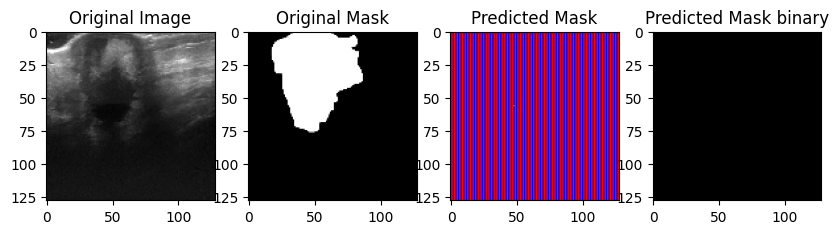

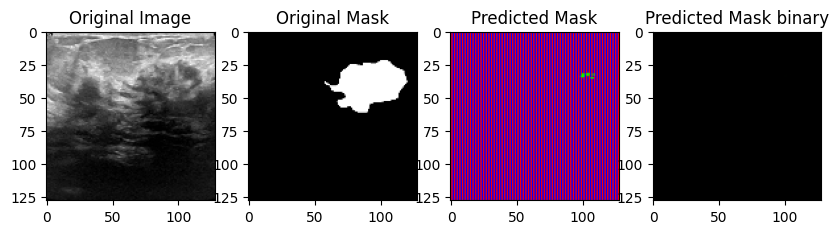

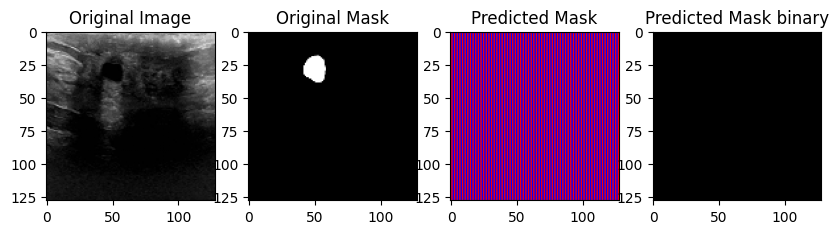

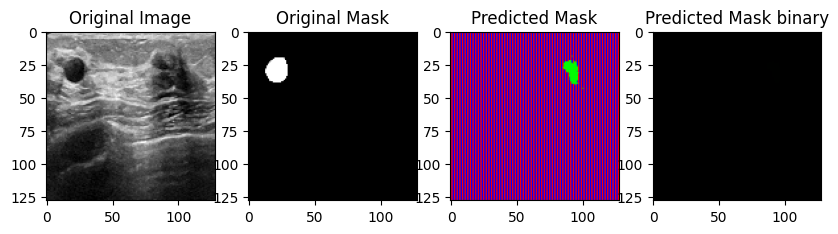

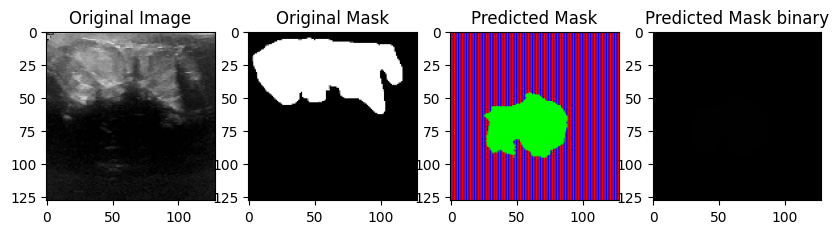

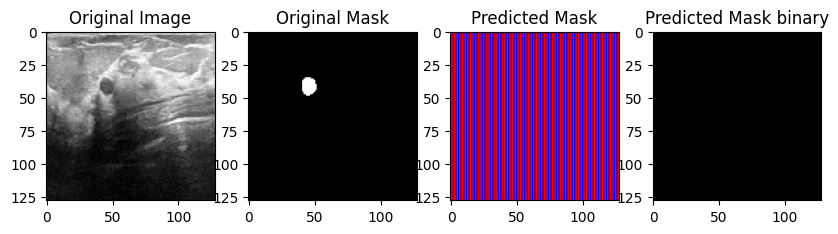

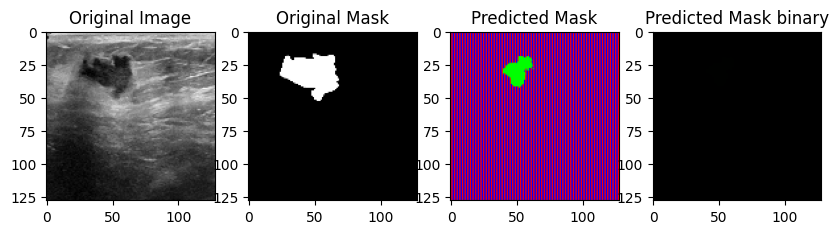

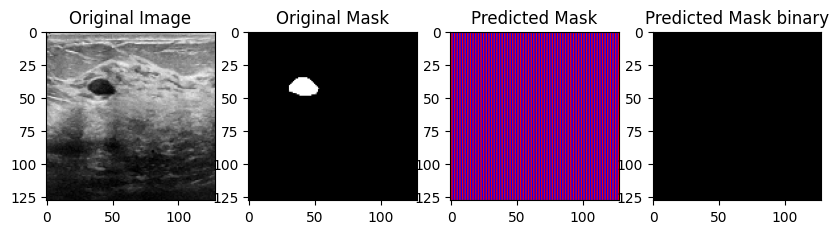

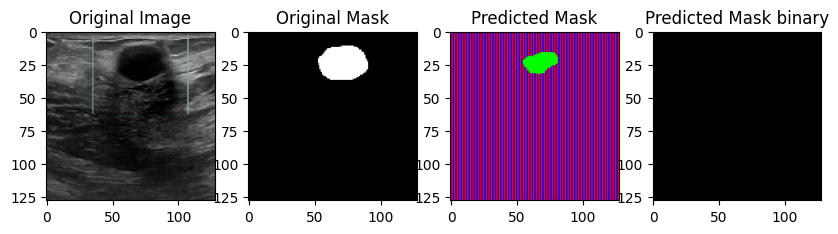

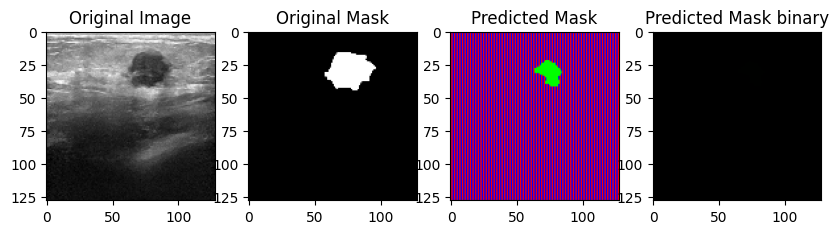

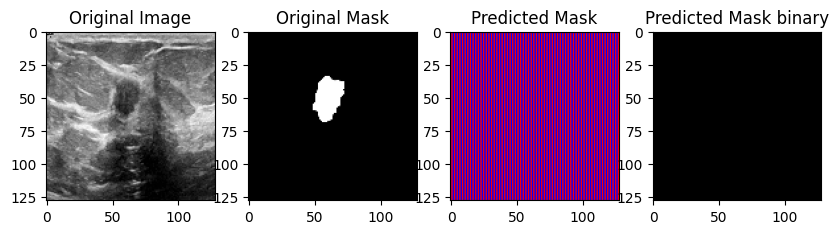

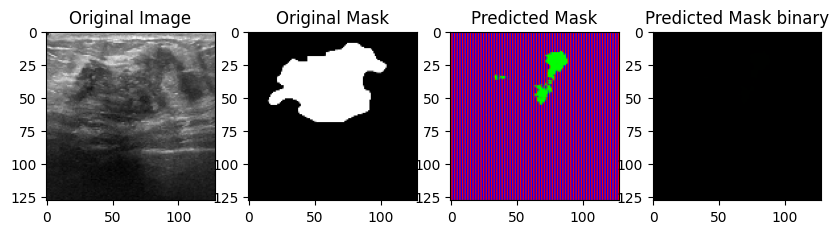

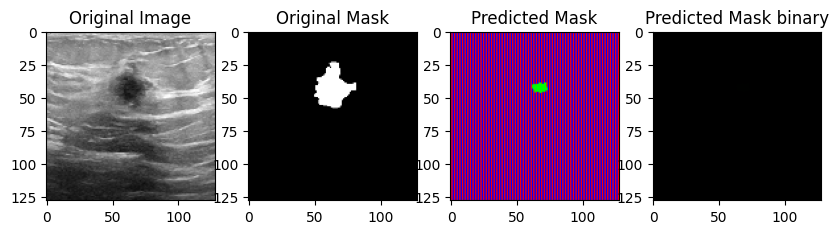

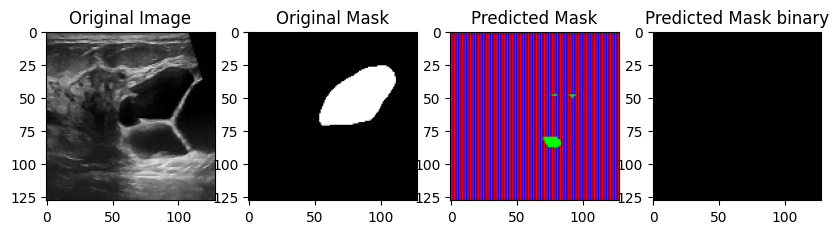

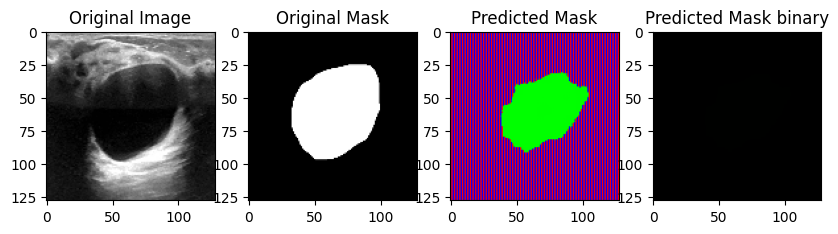

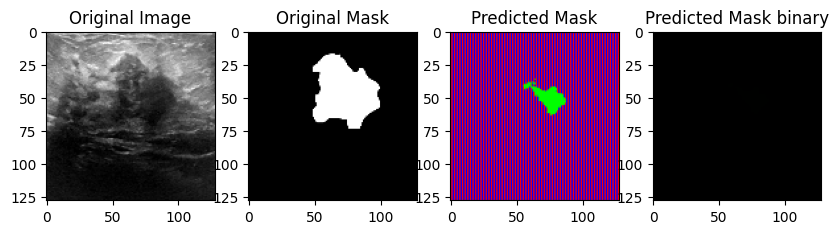

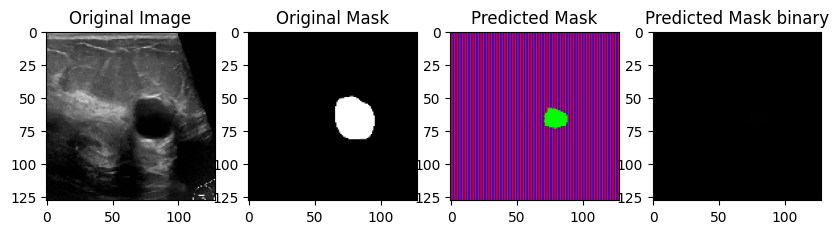

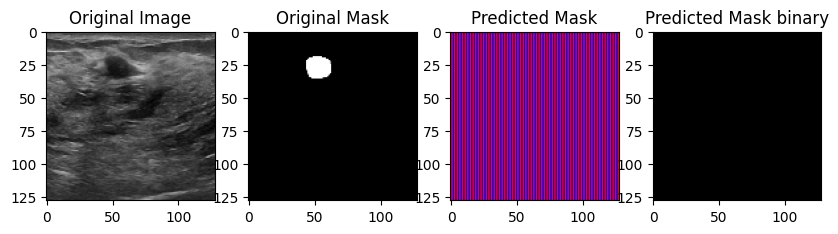

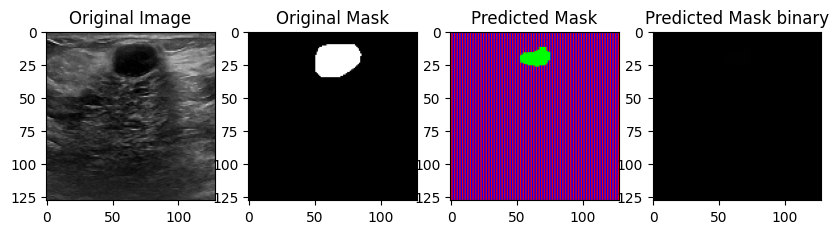

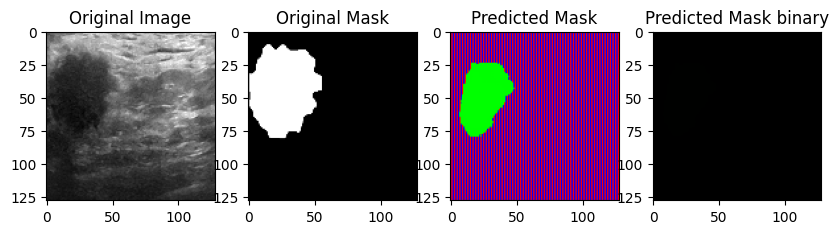

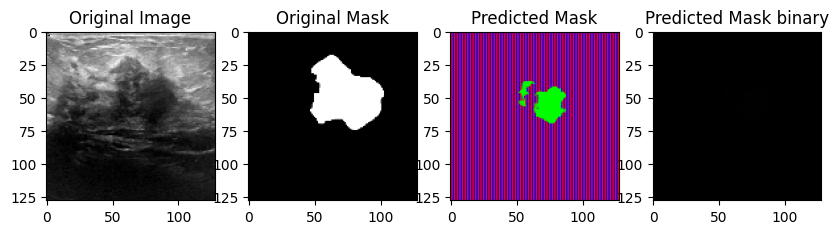

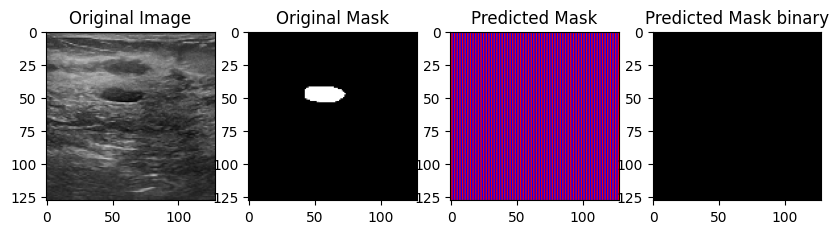

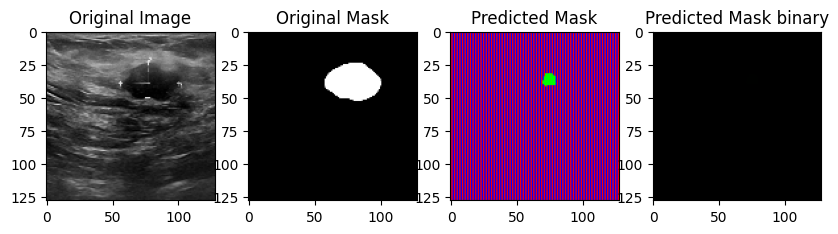

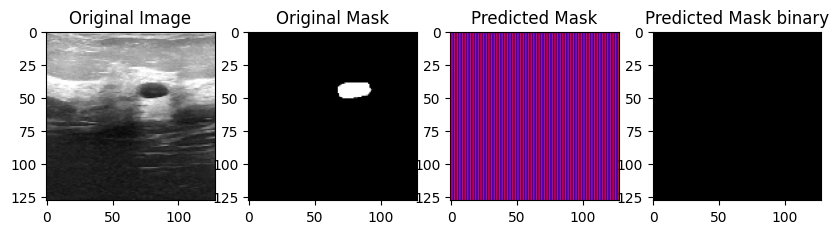

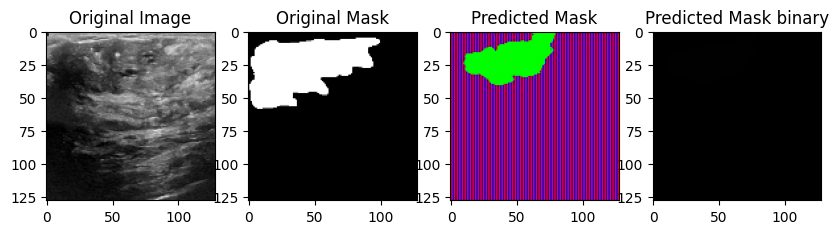

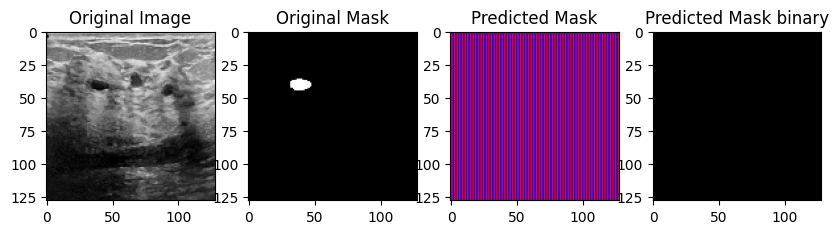

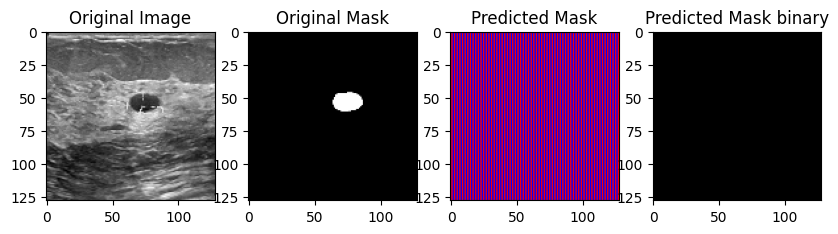

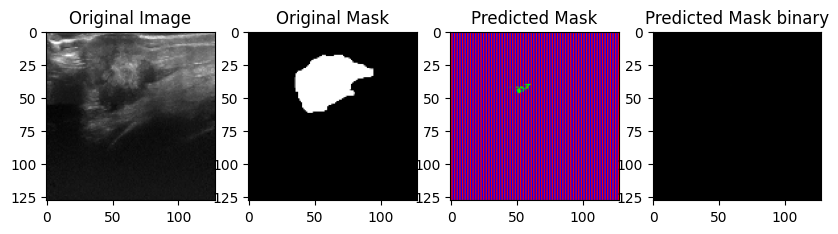

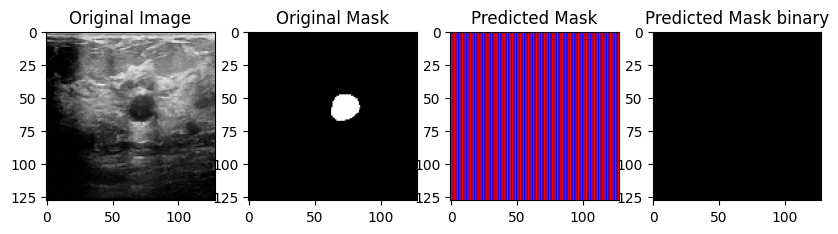

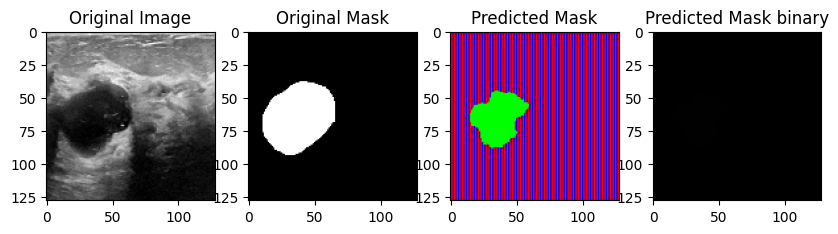

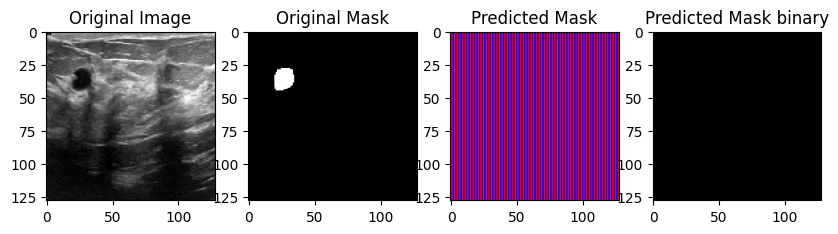

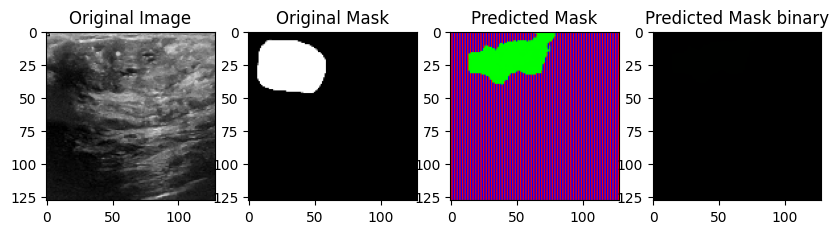

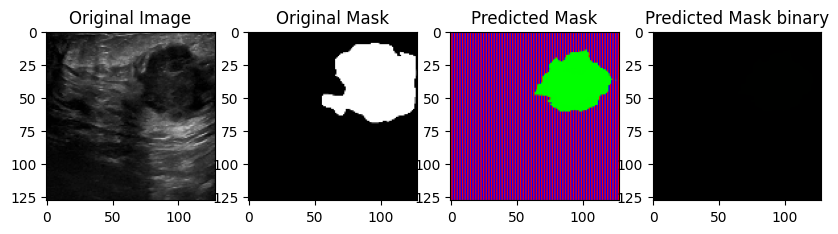

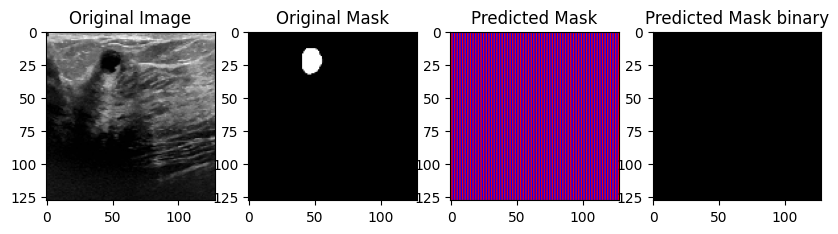

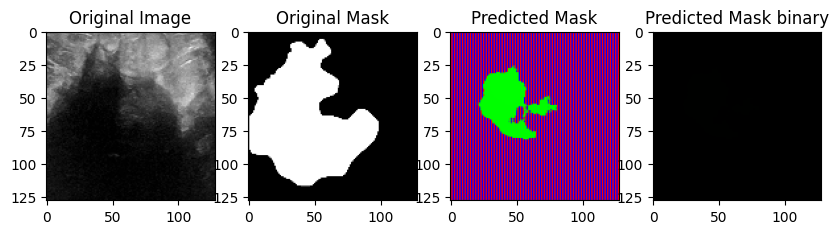

In [24]:
# model.load_weights("{}_Unet_superpixel_skin_SEEDS.best.hdf5".format('cxr_reg'))
model.load_weights("{}_Unet_superpixel_breast_SEEDS.best.hdf5".format('cxr_reg'))


import random
dice_scores = []
import matplotlib.colors as mcolors

for test_path, test_mask_path in zip(test_paths, test_mask_paths):
    # read the image and mask using OpenCV
    test_image = cv2.imread(test_path)
    ground_truth_test_image = cv2.imread(test_mask_path, 0)  # read the mask as grayscale

    # resize the image and mask to the desired dimensions
    test_image = cv2.resize(test_image, (128, 128))
    ground_truth_test_image = cv2.resize(ground_truth_test_image, (128, 128))

    # normalize the image and mask to have values between 0 and 1
    test_image = test_image / 255.0
    ground_truth_test_image = ground_truth_test_image / 255.0

    # add the image and mask to the corresponding arrays
    test_images.append(test_image)
    ground_truth_test_images.append(ground_truth_test_image)

# Convert the images and masks to numpy arrays
test_images = np.array(test_images)
ground_truth_test_images = np.array(ground_truth_test_images)


# Make predictions
predicted_masks = model.predict(test_images)

threshold = 0.5  # You can adjust this threshold as needed

# Create an empty list to store the binary masks
binary_masks = []

# Convert the predicted masks to grayscale
# grayscale_mask = np.mean(predicted_masks, axis=-1)

# Apply the threshold to each predicted mask
for i in range(len(predicted_masks)):
    binary_mask = (predicted_masks[i] > threshold).astype(np.uint8)
    binary_masks.append(binary_mask)

# Convert the list of binary masks to a numpy array
binary_masks = np.array(binary_masks)

# predicted_masks = tf.cast(predicted_mask_array, dtype=tf.float64)
# Apply thresholding

print("predicted mask grayscale shape:",binary_masks.shape)  # Shape after conversion

print("predicted mask shape:", predicted_masks.shape)
print("test images shape :", test_images.shape)
print ("ground truth test images shape:", ground_truth_test_images.shape)

dice_scores = []  # List to store the dice coefficients
precision_scores = []
sensitivity_scores = []
iou_scores = []

# Iterate over the images and calculate the dice coefficient
for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    dice = dice_coef_one_class(y_true, y_pred)
    dice_scores.append(dice)

# Compute the average dice coefficient
average_dice = np.mean(dice_scores)


for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    precision_value = precision_one_class(y_true, y_pred)
    precision_scores.append(precision_value)

# Compute the average dice coefficient
average_precision = np.mean(precision_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    sensitivity_value = sensitivity_one_class(y_true, y_pred)
    sensitivity_scores.append(sensitivity_value)

# Compute the average dice coefficient
average_sensitivity = np.mean(sensitivity_scores)

for i in range(len(ground_truth_test_images)):
    y_true = ground_truth_test_images[i]
    y_pred = predicted_masks[i]

    iou_value = iou_one_class(y_true, y_pred)
    iou_scores.append(iou_value)

# Compute the average dice coefficient
average_iou = np.mean(iou_scores)

print("Dices:", dice_scores)
print("Dice coefficient:", average_dice)
print("Precision:", average_precision)
print("Sensitivity:", average_sensitivity)
print("IoU:", average_iou)


# Define a custom colormap
cmap_binary = mcolors.ListedColormap(['white', 'black'])  # 'black' for foreground, 'white' for background
n = 35
# Visualize the results for a subset of images

for i in range(n):

    fig, ax = plt.subplots(1, 4, figsize=(10, 5))
    ax[0].imshow(test_images[i])
    ax[0].set_title('Original Image')
    ax[1].imshow(ground_truth_test_images[i], cmap='gray')
    ax[1].set_title('Original Mask')
    ax[2].imshow(predicted_masks[i], cmap="gray")
    ax[2].set_title('Predicted Mask')
    ax[3].imshow(binary_masks[i], cmap="gray")
    ax[3].set_title('Predicted Mask binary')
    plt.show()
